<a href="https://colab.research.google.com/github/kkoma2623/VisualComputing/blob/master/Conditional_AutoEncoder_(Tensorflow_2)_kkoma2623.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 오토인코더 (TensorFlow 2)
텐서플로우 2에서 제공하는 고수준 API인 케라스를 이용해, 오토인코더(autoencoder)를 구현한다.
* Google Colab 환경에서 사용하는 경우에  초점을 맞춤.
* 텐서플로우 2
* 텐서플로우 2 내장 케라스 기준

참고문헌
* [TensorFlow 소개](https://www.tensorflow.org/learn)
* [TensorFlow > 학습 > TensorFlow Core > 가이드 > 케라스: 빠르게 훑어보기](https://www.tensorflow.org/guide/keras/overview)
* [Deep Learning with Python, by Francois Chollet](https://github.com/fchollet/deep-learning-with-python-notebooks)



## Tensorflow 2과 Keras를 사용하기 위한 구성
```
import tensorflow as tf                       # 텐서플로우 임포트
from tensorflow.keras import models, layers   # 케라스 관련 모듈 임포트
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)        # 텐서플로우 버전을 확인하도록 한다.
print(tf.keras.__version__)  # 케라스 버전을 확인한다.
```

In [0]:
import tensorflow as tf                       # 텐서플로우 임포트
from tensorflow.keras import models, layers   # 케라스 관련 모듈 임포트
import numpy as np
import matplotlib.pyplot as plt
 
print(tf.__version__)        # 텐서플로우 버전을 확인하도록 한다.
print(tf.keras.__version__)  # 케라스 버전을 확인한다.


2.2.0-rc3
2.3.0-tf


## MNIST 데이터셋 띄우기
* mnist 데이터셋은 LeCun이 만든 숫자(digit) 손글씨 데이터셋이다.
* 60,000개의 트레이닝 데이터와 10,000개의 테스트 데이터로 이루어져 있다.


### MNIST 이미지 데이터
* 트레이닝 이미지와 테스트 이미지에 들어 있는 영상은 3차원 텐서이다.
  + 트레이닝 이미지의 경우, shape = (60000, 28, 28)
  + 테스트 이미지의 경우, shape=(10000, 28, 28)
* 3차원 텐서는 다음의 의미로 구성되어 있음을 유념하자.
  + (# of images, image Height, image Width)  혹은 (# of images, # of Rows, # of Columns)  
* 각 영상은 28 x 28 크기로 구성되어 있다.
* 각 픽셀은 [0, 255] 사이의 uint8형 값이다.
  + 반드시, 텐서플로우에 입력으로 넣을 때, 픽셀값을 [0, 1] 사이의 float64형 값으로 변환하도록 하자.


### MNIST 라벨 데이터
* 각 라벨은 [0, 9] 사이의 unit8형 값이다.

# 아래의 train_images와 test_images의 shape을 바꿔주었다.
* train_images의 shape은 (60000, 1, 28, 28)
* test_images의 shape은 (10000, 1, 28, 28)

In [0]:
# MNIST 데이터 로딩
mnist = tf.keras.datasets.mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

print('train_images의 *원래* 데이터의 shape과 dype:', 
      train_images.shape, train_images.dtype)
print('test_images의 *원래* 데이터의 shape과 dype:', 
      test_images.shape, test_images.dtype)

# Normalizing the images to the range of [0., 1.]
train_images = np.reshape(train_images, (len(train_images), 1, 28, 28))
test_images = np.reshape(test_images, (len(test_images), 1, 28, 28))
train_images = tf.cast(train_images, tf.float32)
test_images  = tf.cast(test_images, tf.float32)
train_images /= 255
test_images  /= 255

print('train_images의 *바뀐* 데이터의 shape과 dype:', 
      train_images.shape, train_images.dtype)
print('test_images의 *바뀐* 데이터의 shape과 dype:', 
      test_images.shape, test_images.dtype)


# Print out for checking
print(train_images[0].shape)
print(train_images[0][0][0].dtype)
print(train_labels.dtype)
# print(train_images[0])

11493376/11490434 [==============================] - 0s 0us/step
train_images의 *원래* 데이터의 shape과 dype: (60000, 28, 28) uint8
test_images의 *원래* 데이터의 shape과 dype: (10000, 28, 28) uint8
train_images의 *바뀐* 데이터의 shape과 dype: (60000, 1, 28, 28) <dtype: 'float32'>
test_images의 *바뀐* 데이터의 shape과 dype: (10000, 1, 28, 28) <dtype: 'float32'>
(1, 28, 28)
<dtype: 'float32'>
uint8


# Convolution layer에 condition을 주기 위해 train_labels와 test_labels의 shape을 바꿔보았다.
* train_labels를 one-hot 벡터로 바꾸고 이를 다시 텐서플로우의 내장함수인 expand_dims 함수를 사용해서 (60000, 10, 1, 1) 텐서로 변환해주었다. 그런 다음 텐서플로우의 내장함수인 tile 함수를 사용해서 (60000, 10, 28, 28)로 변환해주었다.
* test_labels도 위와 같은 방법으로 (10000, 10, 28, 28) 텐서로 변환해주었다.
* 이때 채널이 앞쪽에 오도록 변환이 되었다.
* one-hot 벡터의 형태도 가지고 있기 위해서 train_labels_onehots_vec와 test_labels_onehots_vec 변수에 저장해두었다. 이는 나중에 디코더에서 입력으로 사용할 것이다.

In [0]:
import keras.backend as K
from keras.layers import Lambda

num_classes = 10

train_label_onehots = tf.keras.utils.to_categorical(train_labels, num_classes)
test_label_onehots  = tf.keras.utils.to_categorical(test_labels, num_classes)
train_label_onehots_vec = tf.keras.utils.to_categorical(train_labels, num_classes)
test_label_onehots_vec  = tf.keras.utils.to_categorical(test_labels, num_classes)

train_label_onehots = tf.expand_dims(train_label_onehots, 2)
test_label_onehots = tf.expand_dims(test_label_onehots, 2)
train_label_onehots = tf.expand_dims(train_label_onehots, 3)
test_label_onehots = tf.expand_dims(test_label_onehots, 3)

train_label_onehots = tf.tile(train_label_onehots, (1,1,28,28))
test_label_onehots = tf.tile(test_label_onehots, (1,1,28,28))

# 데이터 변환 확인

print(train_label_onehots[0])
print(train_labels[0])
print(test_label_onehots[0])
print(test_labels[0])
print(train_label_onehots.shape)
print(train_label_onehots_vec.shape)

tf.Tensor(
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]

Using TensorFlow backend.


## 네트워크 모델 설계
* 인코더 모델: 케라스 시퀀셜 모델로 설계
  + InputLayer로 (1, 28, 28) 영상과 (10, 28, 28) condition을 받고, 출력으로 n_dim차원 벡터가 나오도록 함.
* 디코더 모델: 케라스 시퀀셜 모델로 설계
  + InputLayer에서 n_dim차원 벡터와 one-hot 벡터를 받고, 출력으로 (1, 28,28) 영상이 나오도록 함.
* 오토인코더 모델: 인코더, 디코더를 결합하여 설계
  + 주의: InputLayer를 추가해야 곧장 함수로서 활용할 수 있음.


여기서는 n_dim을 수업시간과는 달리 2로 설정한다.
* 즉, n_dim=2

In [0]:
n_dim = 2

# 인코더
* (1, 28, 28)영상과 (10, 28, 28)의 condition을 concatenate하여 (11, 28, 28)로 만들어준다.
* (11, 28, 28) > (16, 28, 28) > (16, 14, 14) > (32, 14, 14) > (32, 7, 7) > (64, 7, 7) > (3136) > (2) 로 변경

In [0]:
img = tf.keras.Input(shape=(1,28,28)) # TF 1.x의 placeholder 역할
con = tf.keras.Input(shape=(10,28,28))   # TF 1.x의 placeholder 역할

enc_conv_1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same', data_format="channels_first")
enc_conv_2 = tf.keras.layers.Conv2D(16, (3, 3), strides=2, activation='relu', padding='same', data_format="channels_first")
enc_conv_3 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', data_format="channels_first")
enc_conv_4 = tf.keras.layers.Conv2D(32, (3, 3), strides=2, activation='relu', padding='same', data_format="channels_first")
enc_conv_5 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', data_format="channels_first")
enc_conv_6 = tf.keras.layers.Flatten()
enc_conv_7 = tf.keras.layers.Dense(n_dim)

x = tf.keras.layers.concatenate([img, con], axis=1)
x = enc_conv_1(x)
x = enc_conv_2(x)
x = enc_conv_3(x)
x = enc_conv_4(x)
x = enc_conv_5(x)
x = enc_conv_6(x)
z = enc_conv_7(x)
print(z.shape)

(None, 2)


# 디코더
* (2)의 벡터와 (10)의 one-hot벡터를 concatenate하여 (12)로 만들어준다.
* (12) > (3136) > (64, 7, 7) > (32, 7, 7) > (32, 14, 14) > (16, 14, 14) > (16, 28, 28) > (11, 28, 28) 로 변경

In [0]:
con_2 = tf.keras.Input(shape=(10,))
dec_conv_dense = tf.keras.layers.Dense(units=64*7*7, activation='relu')
dec_conv_0 = tf.keras.layers.Reshape(target_shape=(64,7,7))
dec_conv_1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', data_format="channels_first")
dec_conv_2 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=2, activation='relu', data_format="channels_first")
dec_conv_3 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same', data_format="channels_first")
dec_conv_4 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=2, activation='relu', data_format="channels_first")
dec_conv_5 = tf.keras.layers.Conv2D(11, (3, 3), activation='relu', padding='same', data_format="channels_first")
dec_conv_6 = tf.keras.layers.Conv2D(1, (3, 3), activation='relu', padding='same', data_format="channels_first")

x = tf.keras.layers.concatenate([z, con_2], axis=1)
x = dec_conv_dense(x)
x = dec_conv_0(x)
x = dec_conv_1(x)
x = dec_conv_2(x)
x = dec_conv_3(x)
x = dec_conv_4(x)
x = dec_conv_5(x)
y_pred = dec_conv_6(x)
print(y_pred.shape)

(None, 1, 28, 28)


In [0]:
ae = tf.keras.Model(inputs=[img, con, con_2], outputs=y_pred)
print(y_pred.shape)
print(con.shape)

(None, 1, 28, 28)
(None, 10, 28, 28)


## 훈련 전, 네트워크 모델을 함수로서 활용
* AutoEncoder ae를 모델로 구성했기 때문에, 지금부터 함수로서 활용 가능 [(효과적인 TensorFlow: 세션 대신 함수)](https://www.tensorflow.org/guide/effective_tf2?hl=ko#%EC%84%B8%EC%85%98_%EB%8C%80%EC%8B%A0_%ED%95%A8%EC%88%98)
  + 단, ae 함수는 batch 단위로 수행됨을 명심할 것.  
    - 단순히, (1, 28, 28) -> ae -> (1, 28, 28)로 동작하지 않고,
    - batch 단위로 (?, 28, 28) -> ae -> (?, 28, 28)로 병렬처리됨.
* 지금은 훈련 전 네트웍이기 때문에 정상적으로 작동하지 않음.

# 입력으로 train_images, train_label_onehots, train_label_onehotes_vec을 주었다.
* train_images = (60000, 1, 28, 28)
* train_label_onehots = (60000, 10, 28, 28)
* train_label_onehots_vec = (60000, 10, 1)

In [0]:
results = ae([train_images, train_label_onehots, train_label_onehots_vec])

print('input shape:', train_images.shape)
print('output shape:', results.shape)

input shape: (60000, 1, 28, 28)
output shape: (60000, 1, 28, 28)


# train_images[idx] 영상에 대한 결과 확인
* ae의 입력 / 출력 가시화
* 아직 학습을 하지 않아서 제대로 된 영상을 출력하지 못한다.

In [0]:
import ipywidgets as widgets

def io_imshow(idx):
  print('GT label:', train_labels[idx])
  plt.subplot(121)
  plt.imshow(np.squeeze(train_images[idx]))
  plt.subplot(122)
  plt.imshow(np.squeeze(results[idx]))
  plt.show()

widgets.interact(io_imshow, idx=widgets.IntSlider(min=0, max=train_images.shape[0]-1, continuous_update=False));


interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=59999), Output()), _d…

## 네트워크 모델 구조 확인
* summary() 함수로 모델의 구조를 텍스트로 프린트할 수 있음.
* plot_model() 함수로 모델의 구조를 텍스트로 프린트할 수 있음.

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1, 28, 28)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 10, 28, 28)] 0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 11, 28, 28)   0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 28, 28)   1600        concatenate[0][0]            

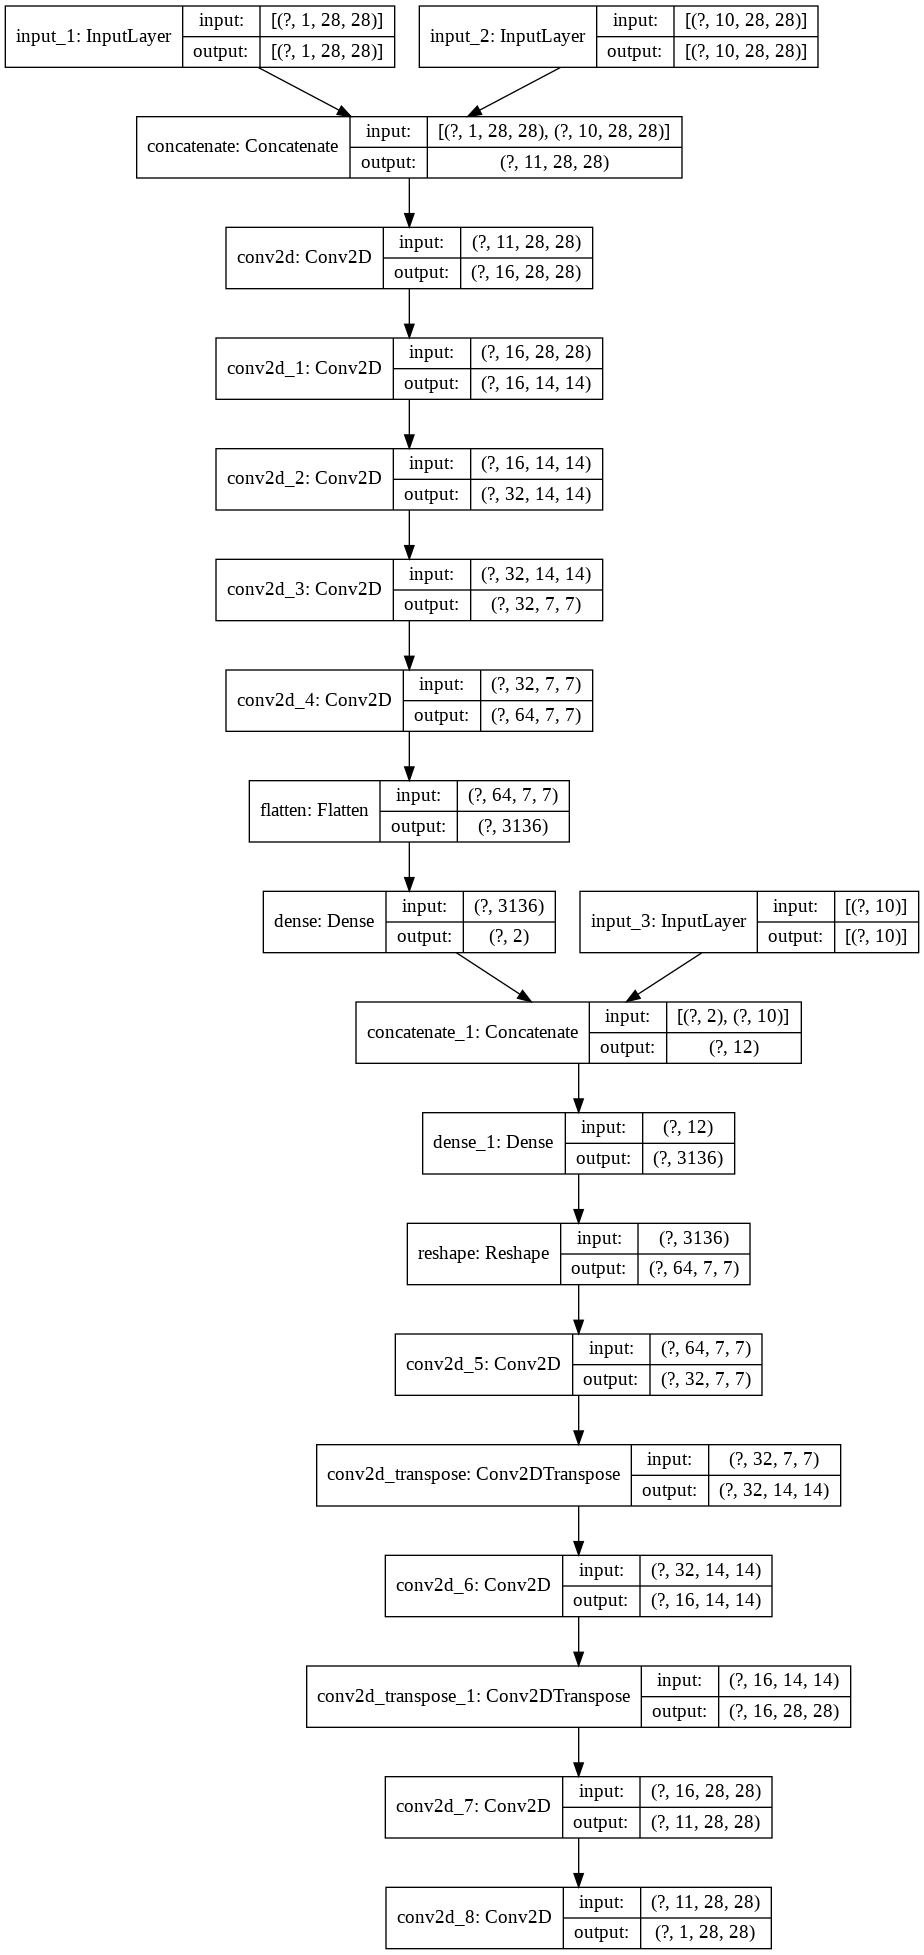

In [0]:
ae.summary()
tf.keras.utils.plot_model(ae, 'ae.png', show_shapes=True)

## 오토인코더 인스턴스 트레이닝

AutoEncoder 인스턴스 ae에 대한 훈련 수행
* 인스턴스 ae를 [compile](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile)
  + cf) shader program 컴파일과 유사하게 이해해도 됨
  + 이때, 훈련에 활용될 [optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers), [loss](https://www.tensorflow.org/api_docs/python/tf/keras/losses), [metrics](https://www.tensorflow.org/api_docs/python/tf/keras/metrics) 등을 지정함
  + Optmizer에 대한 이론적 내용은 [이곳](https://brunch.co.kr/@chris-song/50)을 참고하세요.
* 훈련 데이터 쌍 (train_images, train_label_onehots, train_label_onehots_vec)으로 fit()을 이용해 훈련 


In [0]:
ae.compile(optimizer='adam',
           loss='mse',
           metrics=['mae'])

In [0]:
epochs = 20
batch_size = 100
# ae = tf.keras.Model(inputs=[img, cod], outputs=y_pred)
ae.fit([train_images, train_label_onehots, train_label_onehots_vec], train_images, epochs=epochs, batch_size=batch_size)

Epoch 1/20
600/600 [==============================] - 5s 8ms/step - loss: 0.0424 - mae: 0.0996
Epoch 2/20
600/600 [==============================] - 5s 8ms/step - loss: 0.0340 - mae: 0.0824
Epoch 3/20
600/600 [==============================] - 5s 8ms/step - loss: 0.0332 - mae: 0.0808
Epoch 4/20
600/600 [==============================] - 5s 8ms/step - loss: 0.0328 - mae: 0.0799
Epoch 5/20
600/600 [==============================] - 5s 8ms/step - loss: 0.0325 - mae: 0.0794
Epoch 6/20
600/600 [==============================] - 5s 8ms/step - loss: 0.0323 - mae: 0.0790
Epoch 7/20
600/600 [==============================] - 5s 8ms/step - loss: 0.0322 - mae: 0.0788
Epoch 8/20
600/600 [==============================] - 5s 8ms/step - loss: 0.0321 - mae: 0.0785
Epoch 9/20
600/600 [==============================] - 5s 8ms/step - loss: 0.0319 - mae: 0.0783
Epoch 10/20
600/600 [==============================] - 5s 8ms/step - loss: 0.0319 - mae: 0.0782
Epoch 11/20
600/600 [============================

## 트레이닝이 끝난 오토인코더를 이용하기
트레이닝이 끝난 오토인코더는 함수로서 작동이 가능하다. 

In [0]:
results = ae([train_images, train_label_onehots, train_label_onehots_vec])

In [0]:
import ipywidgets as widgets

def io_imshow(idx):
  print('GT label:', train_labels[idx])
  plt.subplot(121)
  plt.imshow(np.squeeze(train_images[idx]))
  plt.subplot(122)
  plt.imshow(np.squeeze(results[idx]))
  plt.show()

widgets.interact(io_imshow, idx=widgets.IntSlider(min=0, max=train_images.shape[0]-1, continuous_update=False));

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=59999), Output()), _d…

# 디코더를 이용한 Generative Model 구성
## 디코더 부분을 따로 모델로 설정하기
다음과 같은 방법으로 트레이닝이 끝난 조건부 오토인코더의 디코더를 모델로서 활용할 수 있다.


In [0]:
## input layer (special purposes for conditional generative model)
z_sample = layers.Input(shape=(n_dim,))


## conditional generative model
z_cond = layers.concatenate([z_sample, con_2])

x_dec = dec_conv_dense(z_cond)
x_dec = dec_conv_0(x_dec)
x_dec = dec_conv_1(x_dec)
x_dec = dec_conv_2(x_dec)
x_dec = dec_conv_3(x_dec)
x_dec = dec_conv_4(x_dec)
x_dec = dec_conv_5(x_dec)
y_dec_pred = dec_conv_6(x_dec)
print(y_dec_pred.shape)

cond_decoder = models.Model([z_sample, con_2], y_dec_pred)

(None, 1, 28, 28)


## 디코딩 테스트 입력 결과 확인
* 인코딩 결과와 유사한 좌표값을 디코딩에 보내도 유사한 결과가 나옴을 확인한다.

# 손글씨를 생성해보았다.
* 임의의 벡터와 one-hot 벡터를 입력으로 줘보았다.
* 그러기 위해서 one-hot 벡터를 IntSlider를 활용하여 만들고 싶은 손글씨를 선택하여 one-hot벡터를 수정할 수 있도록 하였다.
* 생성해보니 condition을 주지 않는 오토인코더보다 훨씬 잘 생성해내는 것 같다.

In [0]:
## 디코더의 테스트 입력 설정

import ipywidgets as widgets

u=widgets.FloatSlider(min=-5.0, max=5.0)
v=widgets.FloatSlider(min=-5.0, max=5.0)
i=widgets.IntSlider(min=0, max=9)

ui = widgets.HBox([u,v,i])

def z_test(u, v, i):
  z_test = np.array([[u,v]])
  c_test = np.array([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]])
  c_test[0][i] = 1.0
  print(z_test)
  print("one-hot vector > ", c_test)

  img_gen = cond_decoder([z_test, c_test])
  plt.imshow(np.squeeze(img_gen[0]))
  plt.show()  

out = widgets.interactive_output(z_test, {'u': u, 'v': v, 'i':i})

display(ui, out)

Output()

## 인코딩 결과 가시화
오토인코더의 encoder가 만들어 내는 representation인 z 값을 가시화 한다. 

(* 과제!)

# 위에서 학습한 인코더를 가져왔다. 밑으로는 train_images 6000장으로 가시화 해보았다. 밑에 test_images 10000장으로도 가시화 해보겠다.
* train_images와 train_label_onehots를 입력으로 주었다.
* train_images = (60000, 1, 28, 28)
* train_label_onehots = (60000, 10, 28, 28)

In [0]:
## input layer (special purposes for conditional generative model)
z_img = tf.keras.Input(shape=(1,28,28)) # TF 1.x의 placeholder 역할
z_con = tf.keras.Input(shape=(10,28,28))   # TF 1.x의 placeholder 역할

## conditional generative model
z_cond = layers.concatenate([z_img, z_con], axis=1)
z_x = enc_conv_1(z_cond)
z_x = enc_conv_2(z_x)
z_x = enc_conv_3(z_x)
z_x = enc_conv_4(z_x)
z_x = enc_conv_5(z_x)
z_x = enc_conv_6(z_x)
z_enc = enc_conv_7(z_x)
print(z_enc.shape)

cond_encoder = models.Model([z_img, z_con], z_enc)
z_cond_encoder = cond_encoder([train_images, train_label_onehots])

(None, 2)


# 인코더는 현재 2차원을 아웃풋으로 가지기 때문에 한번에 가시화해보았다.
* 어느정도 군집화가 되어있음을 확인할 수 있었다.
  + condition을 주지 않는 오토인코더보다 더 나은 것 같다.

(5923, 2)
(6742, 2)
(5958, 2)
(5949, 2)


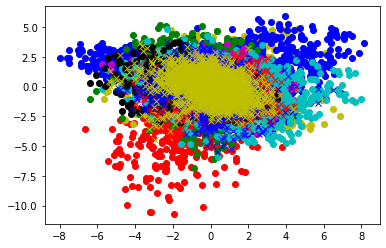

In [0]:
# 로딩된 MNIST 데이터 가시화
import matplotlib.pyplot as plt
z_0 = z_cond_encoder[train_labels==0]    # z 배열을 조건을 이용해 slice
z_1 = z_cond_encoder[train_labels==1]
z_2 = z_cond_encoder[train_labels==2]
z_3 = z_cond_encoder[train_labels==3]
z_4 = z_cond_encoder[train_labels==4]
z_5 = z_cond_encoder[train_labels==5]
z_6 = z_cond_encoder[train_labels==6]
z_7 = z_cond_encoder[train_labels==7]
z_8 = z_cond_encoder[train_labels==8]
z_9 = z_cond_encoder[train_labels==9]

print(z_0.shape)
print(z_1.shape)
print(z_2.shape)
print(z_9.shape)

plt.plot(z_0[:,0], z_0[:,1], 'ro')
plt.plot(z_1[:,0], z_1[:,1], 'yo')
plt.plot(z_2[:,0], z_2[:,1], 'bo')
plt.plot(z_3[:,0], z_3[:,1], 'go')
plt.plot(z_4[:,0], z_4[:,1], 'mo')
plt.plot(z_5[:,0], z_5[:,1], 'co')
plt.plot(z_6[:,0], z_6[:,1], 'ko')
plt.plot(z_7[:,0], z_7[:,1], 'rx')
plt.plot(z_8[:,0], z_8[:,1], 'bx')
plt.plot(z_9[:,0], z_9[:,1], 'yx')

#다음은 TSNE로 가시화해보았다.
* train_images 60000장을 모두 보여주기에는 무리가 있어서 6000장으로 slice하였다.
* 모두 비슷한 위치에서 찍히지만 condition에 따라서 다른 이미지를 생성할 수 있음을 유추할 수 있다.
* encoder가 label 별로 discriminative한 representation을 만들어내지 못하는 것 같다.

(60000, 2)


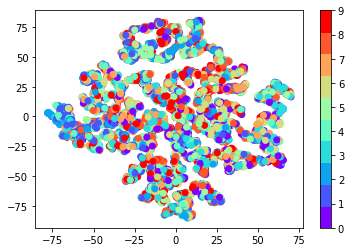

In [0]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

model = TSNE(learning_rate=100)
print(z_cond_encoder.shape)
transformed = model.fit_transform(z_cond_encoder[:6000, :])

xs = transformed[:,0]
ys = transformed[:,1]
plt.scatter(xs,ys,c=train_labels[:6000], cmap=plt.get_cmap('rainbow', 10))
plt.colorbar()
plt.show()

#다음은 TSNE로 라벨별로 가시화해보았다.

(60000, 2)


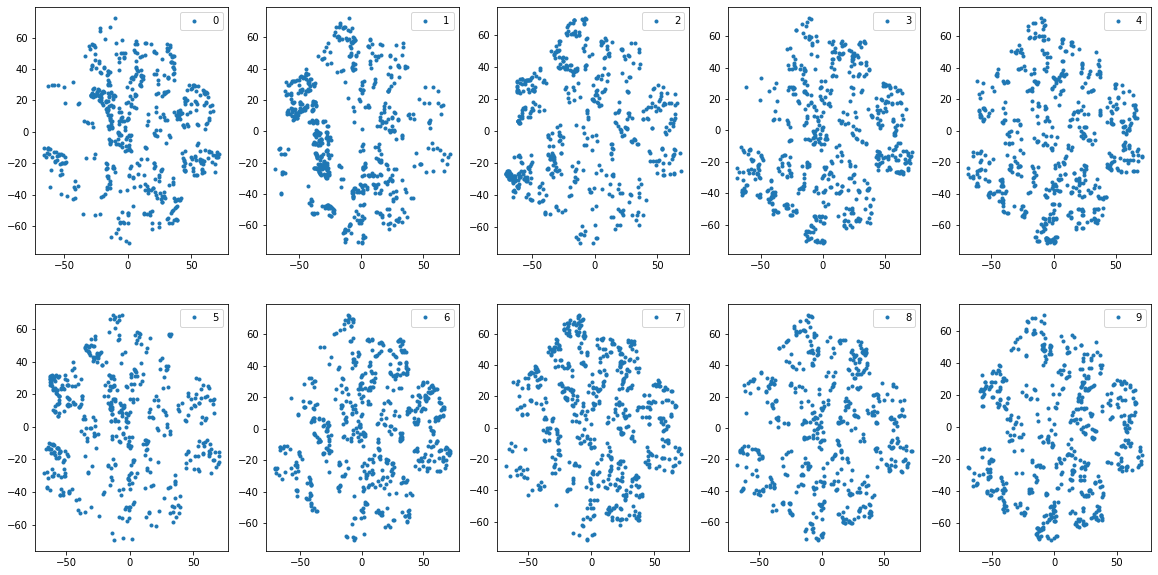

In [0]:
model_label = TSNE(learning_rate=100)
print(z_cond_encoder.shape)
transformed_label = model_label.fit_transform(z_cond_encoder[:6000, :])

xs_label = [[] for _ in range(10)]
ys_label = [[] for _ in range(10)]
for i, j in enumerate(train_labels[:6000]):
    xs_label[j].append(transformed_label[i][0])
    ys_label[j].append(transformed_label[i][1])

plt.figure(figsize=(20,10))
for i in range(1, 11):
    ax = plt.subplot(2,5,i)
    ax.plot(xs_label[i - 1], ys_label[i - 1], '.', label=str(i - 1))
    ax.legend()

plt.show()

# 다음은 test_images 10000장으로 가시화를 해보겠다.

In [0]:
## input layer (special purposes for conditional generative model)
z_img_test = tf.keras.Input(shape=(1,28,28)) # TF 1.x의 placeholder 역할
z_con_test = tf.keras.Input(shape=(10,28,28))   # TF 1.x의 placeholder 역할

## conditional generative model
z_cond_test = layers.concatenate([z_img_test, z_con_test], axis=1)
z_x_test = enc_conv_1(z_cond_test)
z_x_test = enc_conv_2(z_x_test)
z_x_test = enc_conv_3(z_x_test)
z_x_test = enc_conv_4(z_x_test)
z_x_test = enc_conv_5(z_x_test)
z_x_test = enc_conv_6(z_x_test)
z_enc_test = enc_conv_7(z_x_test)
print(z_enc_test.shape)

cond_encoder_test = models.Model([z_img_test, z_con_test], z_enc_test)
z_cond_encoder_test = cond_encoder_test([test_images, test_label_onehots])

(None, 2)


# train_images와 유사한 분포를 보여준다.
* test_images를 데이터로 넣어도 군집화가 잘 되어있음을 확인할 수 있다.

(980, 2)
(1135, 2)
(1032, 2)
(1009, 2)


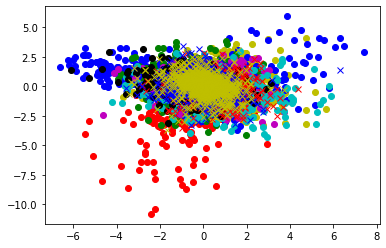

In [0]:
# 로딩된 MNIST 데이터 가시화
import matplotlib.pyplot as plt
z_0_test = z_cond_encoder_test[test_labels==0]    # z 배열을 조건을 이용해 slice
z_1_test = z_cond_encoder_test[test_labels==1]
z_2_test = z_cond_encoder_test[test_labels==2]
z_3_test = z_cond_encoder_test[test_labels==3]
z_4_test = z_cond_encoder_test[test_labels==4]
z_5_test = z_cond_encoder_test[test_labels==5]
z_6_test = z_cond_encoder_test[test_labels==6]
z_7_test = z_cond_encoder_test[test_labels==7]
z_8_test = z_cond_encoder_test[test_labels==8]
z_9_test = z_cond_encoder_test[test_labels==9]

print(z_0_test.shape)
print(z_1_test.shape)
print(z_2_test.shape)
print(z_9_test.shape)

plt.plot(z_0_test[:,0], z_0_test[:,1], 'ro')
plt.plot(z_1_test[:,0], z_1_test[:,1], 'yo')
plt.plot(z_2_test[:,0], z_2_test[:,1], 'bo')
plt.plot(z_3_test[:,0], z_3_test[:,1], 'go')
plt.plot(z_4_test[:,0], z_4_test[:,1], 'mo')
plt.plot(z_5_test[:,0], z_5_test[:,1], 'co')
plt.plot(z_6_test[:,0], z_6_test[:,1], 'ko')
plt.plot(z_7_test[:,0], z_7_test[:,1], 'rx')
plt.plot(z_8_test[:,0], z_8_test[:,1], 'bx')
plt.plot(z_9_test[:,0], z_9_test[:,1], 'yx')

# test_images에 대해서도 TSNE로 가시화를 해보았다.
* train_images와 유사한 분포를 보인다.

(10000, 2)


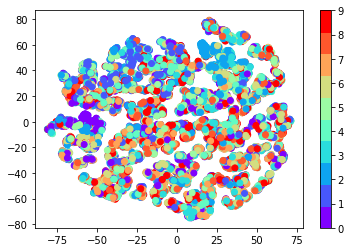

In [0]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

model_test = TSNE(learning_rate=100)
print(z_cond_encoder_test.shape)
transformed_test = model_test.fit_transform(z_cond_encoder_test)

xs_test = transformed_test[:,0]
ys_test = transformed_test[:,1]
plt.scatter(xs_test,ys_test,c=test_labels, cmap=plt.get_cmap('rainbow', 10))
plt.colorbar()
plt.show()

# test_images를 TSNE를 사용하여 라벨별로 가시화해보았다.

(10000, 2)


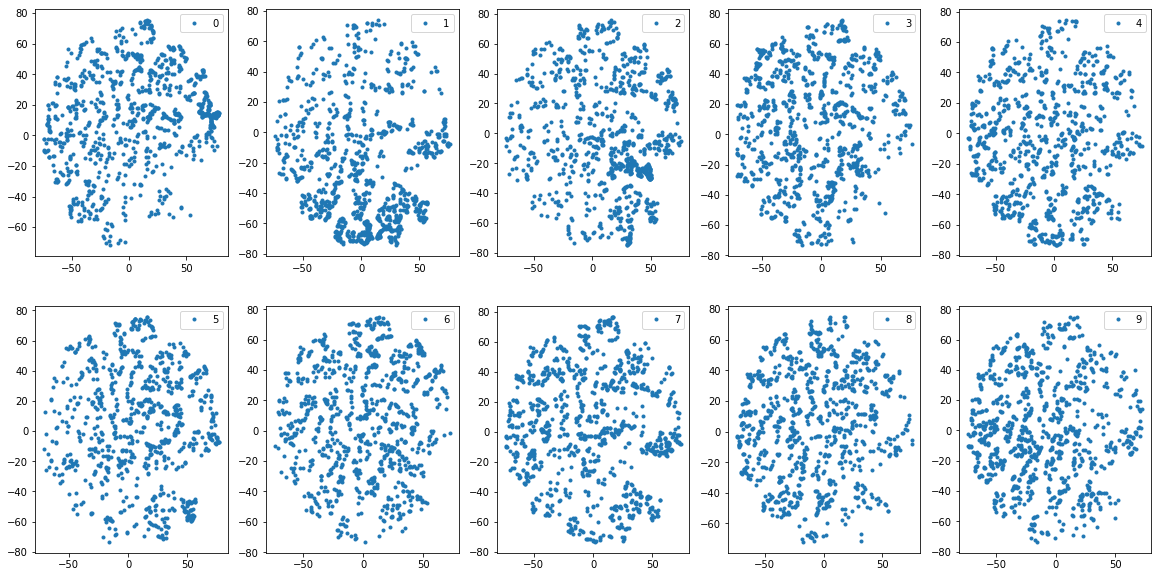

In [0]:
model_label_test = TSNE(learning_rate=100)
print(z_cond_encoder_test.shape)
transformed_label_test = model_label_test.fit_transform(z_cond_encoder_test)

xs_label_test = [[] for _ in range(10)]
ys_label_test = [[] for _ in range(10)]
for i, j in enumerate(test_labels):
    xs_label_test[j].append(transformed_label_test[i][0])
    ys_label_test[j].append(transformed_label_test[i][1])

plt.figure(figsize=(20,10))
for i in range(1, 11):
    ax = plt.subplot(2,5,i)
    ax.plot(xs_label_test[i - 1], ys_label_test[i - 1], '.', label=str(i - 1))
    ax.legend()

plt.show()

# 이제 z의 차원을 10차원으로 변경해서 실험해보겠다.
* 같은 모양의 모델을 만들어서 실험할 것이라 모델에 대한 자세한 설명은 위와 동일하므로 생략하겠다.

In [0]:
n_dim2 = 10

# 인코더
* (11, 28, 28) > (16, 28, 28) > (16, 14, 14) > (32, 14, 14) > (32, 7, 7) > (64, 7, 7) > (3136) > (10) 로 변경

In [0]:
img2 = tf.keras.Input(shape=(1,28,28)) # TF 1.x의 placeholder 역할
con2 = tf.keras.Input(shape=(10,28,28))   # TF 1.x의 placeholder 역할

enc_conv_1_2 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same', data_format="channels_first")
enc_conv_2_2 = tf.keras.layers.Conv2D(16, (3, 3), strides=2, activation='relu', padding='same', data_format="channels_first")
enc_conv_3_2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', data_format="channels_first")
enc_conv_4_2 = tf.keras.layers.Conv2D(32, (3, 3), strides=2, activation='relu', padding='same', data_format="channels_first")
enc_conv_5_2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', data_format="channels_first")
enc_conv_6_2 = tf.keras.layers.Flatten()
enc_conv_7_2 = tf.keras.layers.Dense(n_dim2)

x2 = tf.keras.layers.concatenate([img2, con2], axis=1)
x2 = enc_conv_1_2(x2)
x2 = enc_conv_2_2(x2)
x2 = enc_conv_3_2(x2)
x2 = enc_conv_4_2(x2)
x2 = enc_conv_5_2(x2)
x2 = enc_conv_6_2(x2)
z2 = enc_conv_7_2(x2)
print(z2.shape)

(None, 10)


# 디코더
* (20) > (3136) > (64, 7, 7) > (32, 7, 7) > (32, 14, 14) > (16, 14, 14) > (16, 28, 28) > (11, 28, 28) 로 변경

In [0]:
con_2_2 = tf.keras.Input(shape=(10,))
dec_conv_dense_2 = tf.keras.layers.Dense(units=64*7*7, activation='relu')
dec_conv_0_2 = tf.keras.layers.Reshape(target_shape=(64,7,7))
dec_conv_1_2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', data_format="channels_first")
dec_conv_2_2 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=2, activation='relu', data_format="channels_first")
dec_conv_3_2 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same', data_format="channels_first")
dec_conv_4_2 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=2, activation='relu', data_format="channels_first")
dec_conv_5_2 = tf.keras.layers.Conv2D(11, (3, 3), activation='relu', padding='same', data_format="channels_first")
dec_conv_6_2 = tf.keras.layers.Conv2D(1, (3, 3), activation='relu', padding='same', data_format="channels_first")

x2 = tf.keras.layers.concatenate([z2, con_2_2], axis=1)
x2 = dec_conv_dense_2(x2)
x2 = dec_conv_0_2(x2)
x2 = dec_conv_1_2(x2)
x2 = dec_conv_2_2(x2)
x2 = dec_conv_3_2(x2)
x2 = dec_conv_4_2(x2)
x2 = dec_conv_5_2(x2)
y_pred2 = dec_conv_6_2(x2)
print(y_pred2.shape)

(None, 1, 28, 28)


In [0]:
ae2 = tf.keras.Model(inputs=[img2, con2, con_2_2], outputs=y_pred2)
print(y_pred2.shape)
print(con2.shape)

(None, 1, 28, 28)
(None, 10, 28, 28)


In [0]:
results2 = ae2([train_images, train_label_onehots, train_label_onehots_vec])

print('input shape:', train_images.shape)
print('output shape:', results2.shape)

input shape: (60000, 1, 28, 28)
output shape: (60000, 1, 28, 28)


# train_images[idx] 영상에 대한 결과 확인
* ae의 입력 / 출력 가시화
* 아직 학습을 하지 않아서 제대로 된 영상을 출력하지 못한다.

In [0]:
import ipywidgets as widgets

def io_imshow2(idx):
  print('GT label:', train_labels[idx])
  plt.subplot(121)
  plt.imshow(np.squeeze(train_images[idx]))
  plt.subplot(122)
  plt.imshow(np.squeeze(results2[idx]))
  plt.show()

widgets.interact(io_imshow2, idx=widgets.IntSlider(min=0, max=train_images.shape[0]-1, continuous_update=False));


interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=59999), Output()), _d…

## 네트워크 모델 구조 확인

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 1, 28, 28)]  0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 10, 28, 28)] 0                                            
__________________________________________________________________________________________________
concatenate_5 (Concatenate)     (None, 11, 28, 28)   0           input_9[0][0]                    
                                                                 input_10[0][0]                   
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 16, 28, 28)   1600        concatenate_5[0][0]        

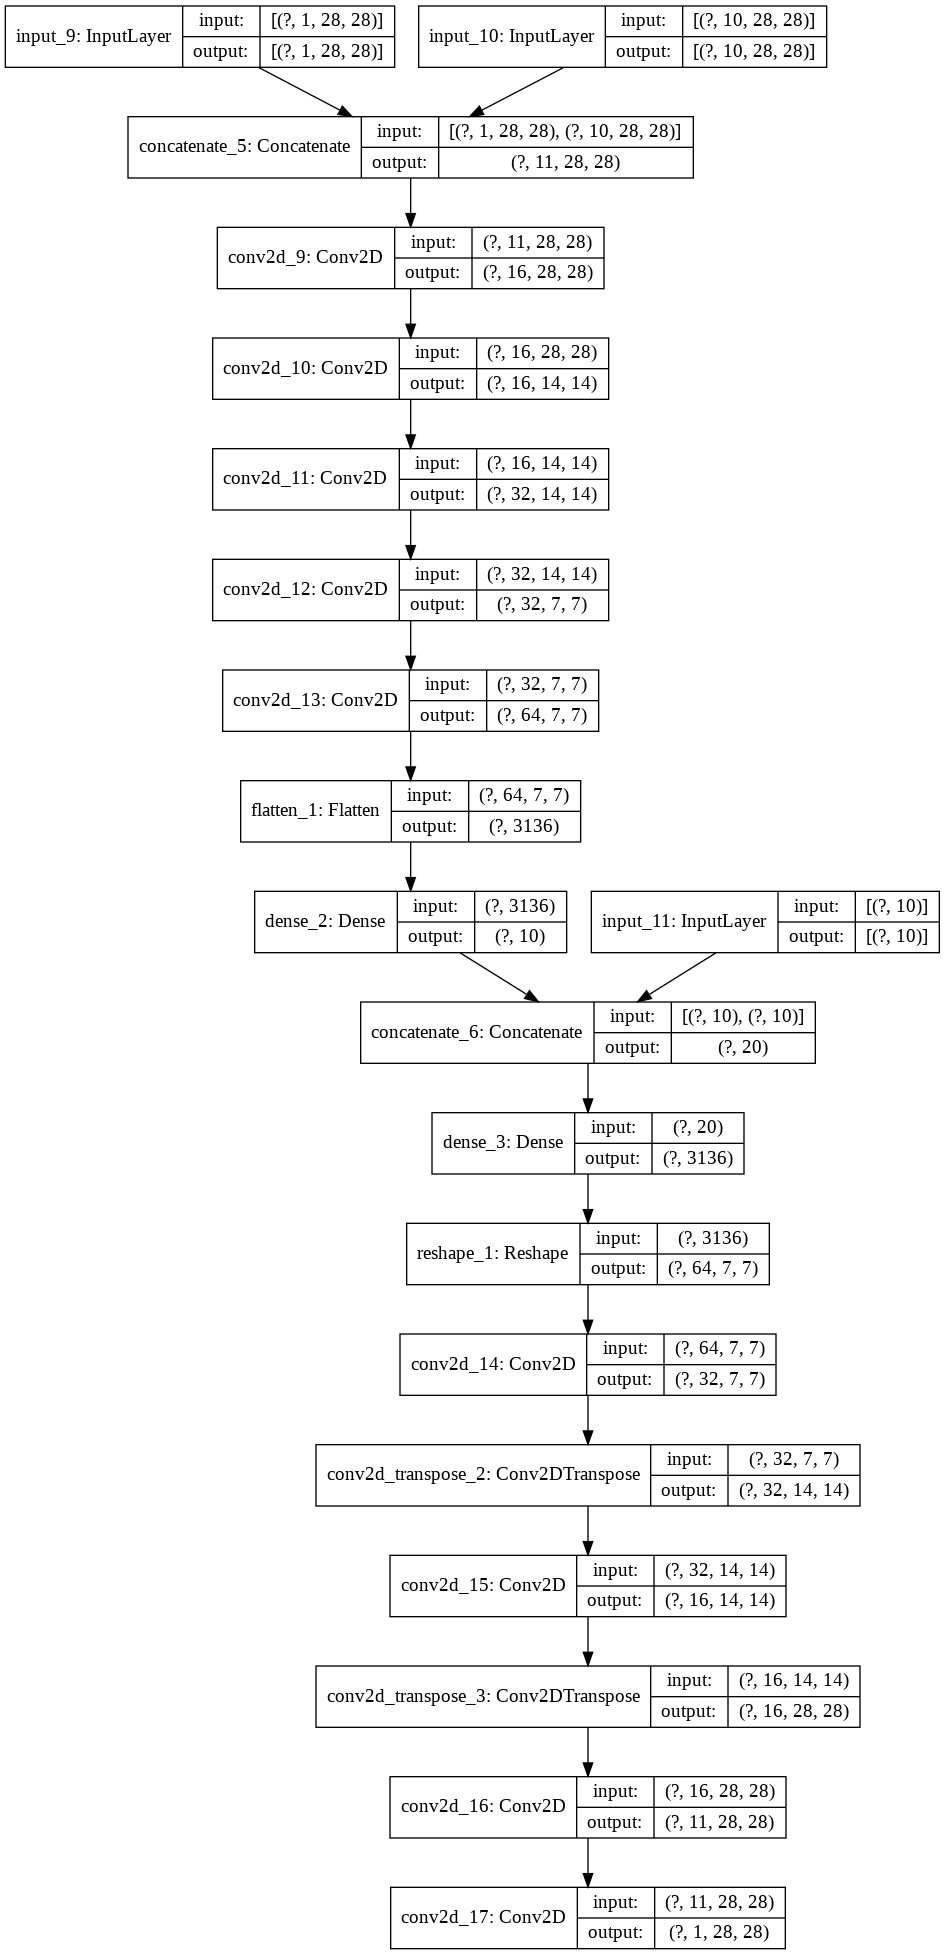

In [0]:
ae2.summary()
tf.keras.utils.plot_model(ae2, 'ae2.png', show_shapes=True)

## 오토인코더 인스턴스 트레이닝

In [0]:
ae2.compile(optimizer='adam',
           loss='mse',
           metrics=['mae'])

In [0]:
epochs = 20
batch_size = 100
# ae = tf.keras.Model(inputs=[img, cod], outputs=y_pred)
ae2.fit([train_images, train_label_onehots, train_label_onehots_vec], train_images, epochs=epochs, batch_size=batch_size)

Epoch 1/20
600/600 [==============================] - 5s 8ms/step - loss: 0.0274 - mae: 0.0704
Epoch 2/20
600/600 [==============================] - 5s 8ms/step - loss: 0.0141 - mae: 0.0420
Epoch 3/20
600/600 [==============================] - 5s 8ms/step - loss: 0.0124 - mae: 0.0384
Epoch 4/20
600/600 [==============================] - 5s 8ms/step - loss: 0.0115 - mae: 0.0364
Epoch 5/20
600/600 [==============================] - 5s 8ms/step - loss: 0.0109 - mae: 0.0351
Epoch 6/20
600/600 [==============================] - 5s 8ms/step - loss: 0.0105 - mae: 0.0342
Epoch 7/20
600/600 [==============================] - 5s 8ms/step - loss: 0.0102 - mae: 0.0334
Epoch 8/20
600/600 [==============================] - 5s 8ms/step - loss: 0.0099 - mae: 0.0328
Epoch 9/20
600/600 [==============================] - 5s 8ms/step - loss: 0.0097 - mae: 0.0324
Epoch 10/20
600/600 [==============================] - 5s 8ms/step - loss: 0.0095 - mae: 0.0319
Epoch 11/20
600/600 [============================

## 트레이닝이 끝난 오토인코더를 이용하기
트레이닝이 끝난 오토인코더는 함수로서 작동이 가능하다. 

In [0]:
results2 = ae2([train_images, train_label_onehots, train_label_onehots_vec])

In [0]:
import ipywidgets as widgets

def io_imshow2(idx):
  print('GT label:', train_labels[idx])
  plt.subplot(121)
  plt.imshow(np.squeeze(train_images[idx]))
  plt.subplot(122)
  plt.imshow(np.squeeze(results2[idx]))
  plt.show()

widgets.interact(io_imshow2, idx=widgets.IntSlider(min=0, max=train_images.shape[0]-1, continuous_update=False));

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=59999), Output()), _d…

# 디코더를 이용한 Generative Model 구성
## 디코더 부분을 따로 모델로 설정하기
다음과 같은 방법으로 트레이닝이 끝난 조건부 오토인코더의 디코더를 모델로서 활용할 수 있다.


In [0]:
## input layer (special purposes for conditional generative model)
z_sample2 = layers.Input(shape=(n_dim2,))


## conditional generative model
z_cond2 = layers.concatenate([z_sample2, con_2])

x_dec2 = dec_conv_dense_2(z_cond2)
x_dec2 = dec_conv_0_2(x_dec2)
x_dec2 = dec_conv_1_2(x_dec2)
x_dec2 = dec_conv_2_2(x_dec2)
x_dec2 = dec_conv_3_2(x_dec2)
x_dec2 = dec_conv_4_2(x_dec2)
x_dec2 = dec_conv_5_2(x_dec2)
y_dec_pred2 = dec_conv_6_2(x_dec2)
print(y_dec_pred2.shape)

cond_decoder2 = models.Model([z_sample2, con_2], y_dec_pred2)

(None, 1, 28, 28)


## 디코딩 테스트 입력 결과 확인
* 인코딩 결과와 유사한 좌표값을 디코딩에 보내도 유사한 결과가 나옴을 확인한다.

# 손글씨를 생성해보았다.
* 임의의 n_dim 벡터와 one-hot 벡터를 입력으로 줘보았다.
* 그러기 위해서 one-hot 벡터를 IntSlider를 활용하여 만들고 싶은 손글씨를 선택하여 one-hot벡터를 수정할 수 있도록 하였다.
* 생성해보니 condition을 주지 않는 오토인코더보다 훨씬 잘 생성해내는 것 같다.
* 하지만 n_dim 이 2 였을 때 보다 모든 임의의 벡터에서 손글씨를 생성해내는 것은 무리가 있는 것 같다.

In [0]:
## 디코더의 테스트 입력 설정

import ipywidgets as widgets

u0_2=widgets.FloatSlider(min=-5.0, max=5.0)
v0_2=widgets.FloatSlider(min=-5.0, max=5.0)
u1_2=widgets.FloatSlider(min=-5.0, max=5.0)
v1_2=widgets.FloatSlider(min=-5.0, max=5.0)
u2_2=widgets.FloatSlider(min=-5.0, max=5.0)
v2_2=widgets.FloatSlider(min=-5.0, max=5.0)
u3_2=widgets.FloatSlider(min=-5.0, max=5.0)
v3_2=widgets.FloatSlider(min=-5.0, max=5.0)
u4_2=widgets.FloatSlider(min=-5.0, max=5.0)
v4_2=widgets.FloatSlider(min=-5.0, max=5.0)
i_2=widgets.IntSlider(min=0, max=9)

ui2 = widgets.HBox([u0_2,v0_2,u1_2,v1_2,u2_2,v2_2,u3_2,v3_2,u4_2,v4_2,i_2])

def z_test2(u0_2,v0_2,u1_2,v1_2,u2_2,v2_2,u3_2,v3_2,u4_2,v4_2,i_2):
  z_test2 = np.array([[u0_2,v0_2,u1_2,v1_2,u2_2,v2_2,u3_2,v3_2,u4_2,v4_2]])
  c_test2 = np.array([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]])
  c_test2[0][i_2] = 1.0
  print(z_test2)
  print("one-hot vector > ", c_test2)

  img_gen2 = cond_decoder2([z_test2, c_test2])
  plt.imshow(np.squeeze(img_gen2[0]))
  plt.show()  

out2 = widgets.interactive_output(z_test2, {'u0_2': u0_2, 'v0_2': v0_2,'u1_2': u1_2, 'v1_2': v1_2,'u2_2': u2_2, 'v2_2': v2_2,'u3_2': u3_2, 'v3_2': v3_2,'u4_2': u4_2, 'v4_2': v4_2, 'i_2':i_2})

display(ui2, out2)

Output()

# 위에서 학습한 인코더를 가져왔다. 밑으로는 train_images 6000장으로 가시화 해보았다. 밑에 test_images 10000장으로도 가시화 해보겠다.
* train_images와 train_label_onehots를 입력으로 주었다.
* train_images = (60000, 1, 28, 28)
* train_label_onehots = (60000, 10, 28, 28)

In [0]:
## input layer (special purposes for conditional generative model)
z_img2 = tf.keras.Input(shape=(1,28,28)) # TF 1.x의 placeholder 역할
z_con2 = tf.keras.Input(shape=(10,28,28))   # TF 1.x의 placeholder 역할

## conditional generative model
z_cond2 = layers.concatenate([z_img2, z_con2], axis=1)
z_x2 = enc_conv_1_2(z_cond2)
z_x2 = enc_conv_2_2(z_x2)
z_x2 = enc_conv_3_2(z_x2)
z_x2 = enc_conv_4_2(z_x2)
z_x2 = enc_conv_5_2(z_x2)
z_x2 = enc_conv_6_2(z_x2)
z_enc2 = enc_conv_7_2(z_x2)
print(z_enc2.shape)

cond_encoder2 = models.Model([z_img2, z_con2], z_enc2)
z_cond_encoder2 = cond_encoder2([train_images, train_label_onehots])

(None, 10)


#다음은 TSNE로 가시화해보았다.
* n_dim이 10이라서 바로 TSNE로 가시화 해보았다.
* train_images 60000장을 모두 보여주기에는 무리가 있어서 6000장으로 slice하였다.
* 군집화가 잘 되어있음을 확인할 수 있다. 즉 encoder가 label 별로 discriminative한 representation을 만들어내는 것 같다.
* condition에 따라서 다른 이미지를 생성할 수 있음을 유추할 수 있다.

(60000, 10)


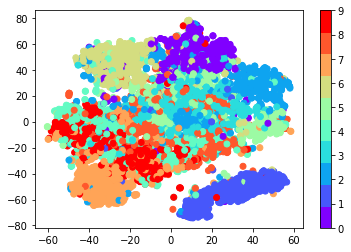

In [0]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

model2 = TSNE(learning_rate=100)
print(z_cond_encoder2.shape)
transformed2 = model2.fit_transform(z_cond_encoder2[:6000, :])

xs2 = transformed2[:,0]
ys2 = transformed2[:,1]
plt.scatter(xs2,ys2,c=train_labels[:6000], cmap=plt.get_cmap('rainbow', 10))
plt.colorbar()
plt.show()

#다음은 TSNE로 라벨별로 가시화해보았다.
* n_dim 차원이 2일때 보다 10일때 encoder가 label 별로 discriminative한 representation을 만들어내는 것을 확인할 수 있다.

(60000, 10)


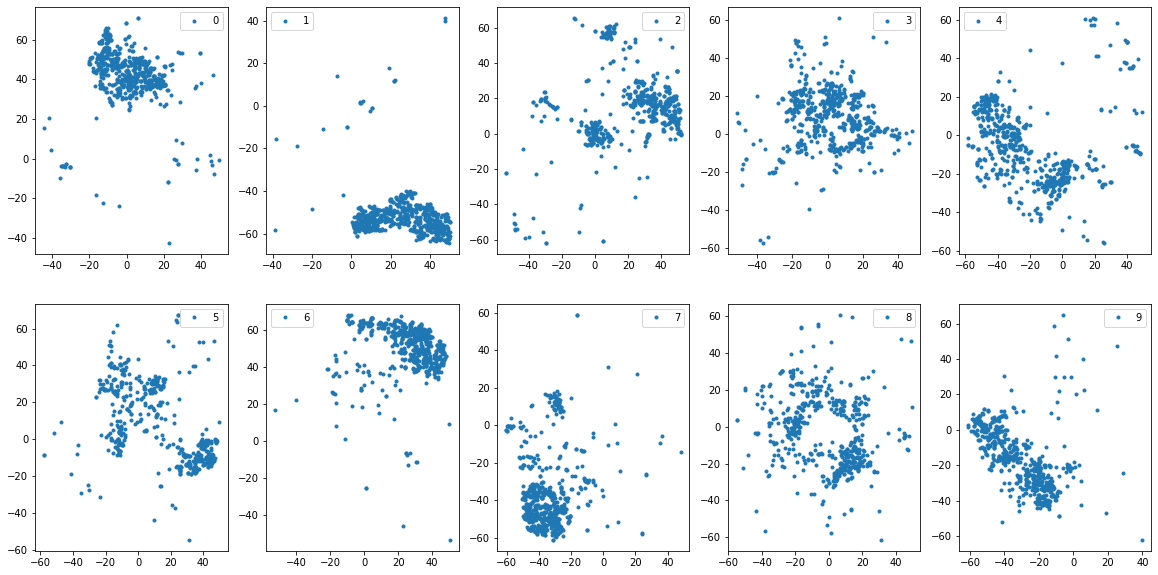

In [0]:
model_label2 = TSNE(learning_rate=100)
print(z_cond_encoder2.shape)
transformed_label2 = model_label2.fit_transform(z_cond_encoder2[:6000, :])

xs_label2 = [[] for _ in range(10)]
ys_label2 = [[] for _ in range(10)]
for i, j in enumerate(train_labels[:6000]):
    xs_label2[j].append(transformed_label2[i][0])
    ys_label2[j].append(transformed_label2[i][1])

plt.figure(figsize=(20,10))
for i in range(1, 11):
    ax2 = plt.subplot(2,5,i)
    ax2.plot(xs_label2[i - 1], ys_label2[i - 1], '.', label=str(i - 1))
    ax2.legend()

plt.show()

# 다음은 test_images 10000장으로 가시화를 해보겠다.

In [0]:
## input layer (special purposes for conditional generative model)
z_img_test2 = tf.keras.Input(shape=(1,28,28)) # TF 1.x의 placeholder 역할
z_con_test2 = tf.keras.Input(shape=(10,28,28))   # TF 1.x의 placeholder 역할

## conditional generative model
z_cond_test2 = layers.concatenate([z_img_test2, z_con_test2], axis=1)
z_x_test2 = enc_conv_1_2(z_cond_test2)
z_x_test2 = enc_conv_2_2(z_x_test2)
z_x_test2 = enc_conv_3_2(z_x_test2)
z_x_test2 = enc_conv_4_2(z_x_test2)
z_x_test2 = enc_conv_5_2(z_x_test2)
z_x_test2 = enc_conv_6_2(z_x_test2)
z_enc_test2 = enc_conv_7_2(z_x_test2)
print(z_enc_test2.shape)

cond_encoder_test2 = models.Model([z_img_test2, z_con_test2], z_enc_test2)
z_cond_encoder_test2 = cond_encoder_test2([test_images, test_label_onehots])

(None, 10)


# test_images에 대해서도 TSNE로 가시화를 해보았다.
* train_images와 유사한 분포를 보인다.

(10000, 10)


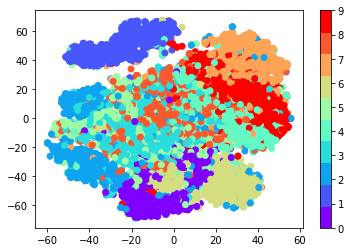

In [0]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

model_test2 = TSNE(learning_rate=100)
print(z_cond_encoder_test2.shape)
transformed_test2 = model_test2.fit_transform(z_cond_encoder_test2)

xs_test2 = transformed_test2[:,0]
ys_test2 = transformed_test2[:,1]
plt.scatter(xs_test2,ys_test2,c=test_labels, cmap=plt.get_cmap('rainbow', 10))
plt.colorbar()
plt.show()

# test_images를 TSNE를 사용하여 라벨별로 가시화해보았다.
* test_images에서도 n_dim 차원이 2일때 보다 encoder가 label 별로 discriminative한 representation을 만들어내는 것을 확인할 수 있다.

(10000, 10)


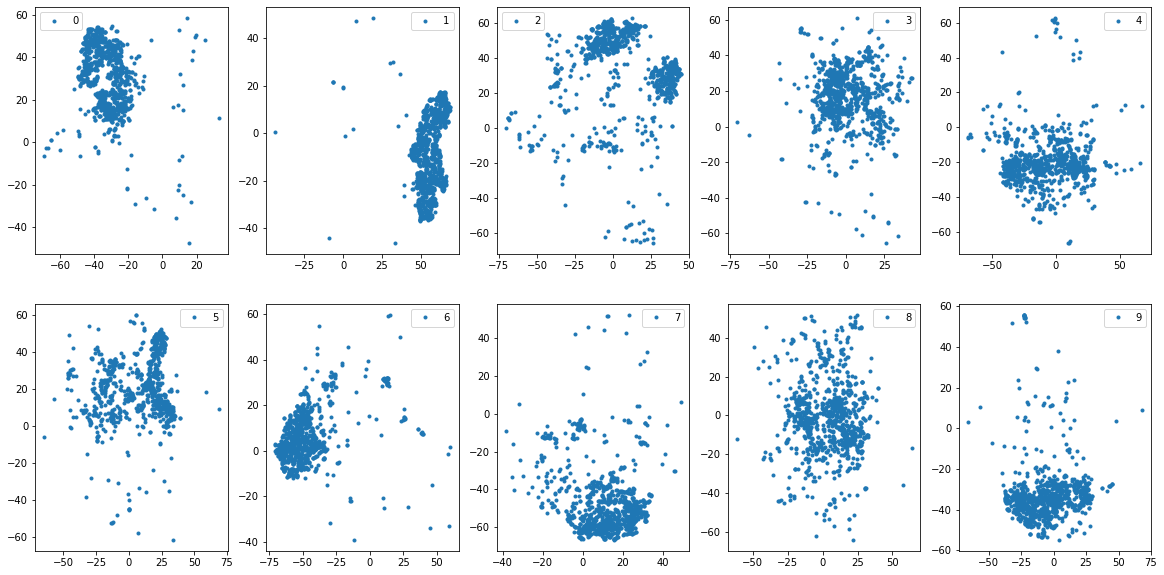

In [0]:
model_label_test2 = TSNE(learning_rate=100)
print(z_cond_encoder_test2.shape)
transformed_label_test2 = model_label_test2.fit_transform(z_cond_encoder_test2)

xs_label_test2 = [[] for _ in range(10)]
ys_label_test2 = [[] for _ in range(10)]
for i, j in enumerate(test_labels):
    xs_label_test2[j].append(transformed_label_test2[i][0])
    ys_label_test2[j].append(transformed_label_test2[i][1])

plt.figure(figsize=(20,10))
for i in range(1, 11):
    ax = plt.subplot(2,5,i)
    ax.plot(xs_label_test2[i - 1], ys_label_test2[i - 1], '.', label=str(i - 1))
    ax.legend()

plt.show()